In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import cuda
import dezero.functions as F
import dezero.layers as L
from dezero import DataLoader
from dezero.models import Sequential
from dezero.optimizers import Adam
use_gpu = cuda.gpu_enable
print(use_gpu)


True


In [3]:
transform = lambda x: (x / 255.0).astype(np.float32)
train_set = dezero.datasets.MNIST(train=True, transform=transform)
train_loader = DataLoader(train_set, 32)


In [8]:
train_set

epoch: 0.21, loss_g: 0.9215, loss_d: 1.1537


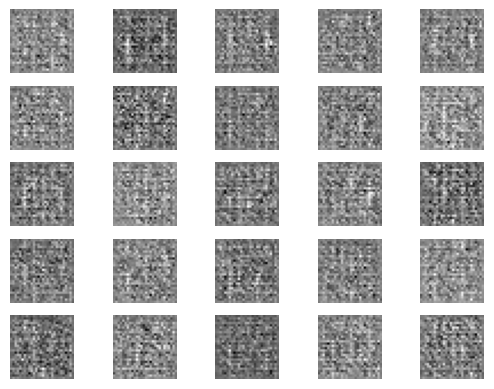

epoch: 0.43, loss_g: 1.0824, loss_d: 0.9963


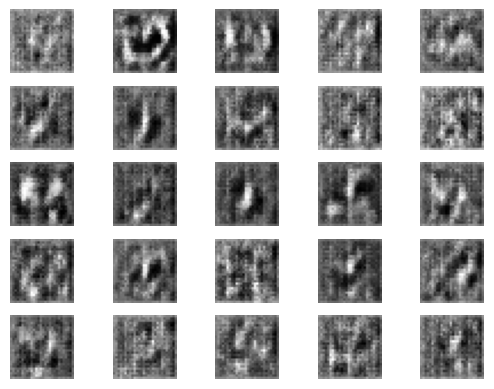

epoch: 0.64, loss_g: 1.2012, loss_d: 0.8902


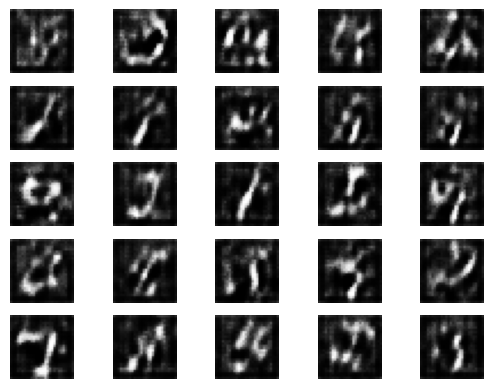

epoch: 0.85, loss_g: 1.2744, loss_d: 0.8594


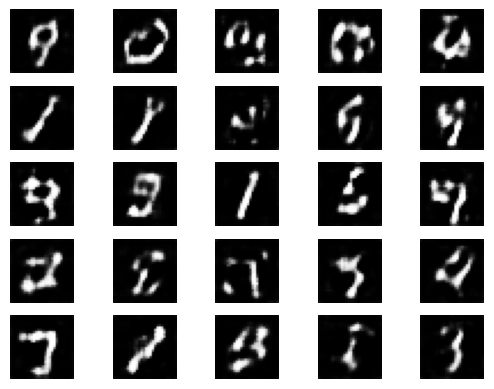

epoch: 1.21, loss_g: 1.1910, loss_d: 0.9898


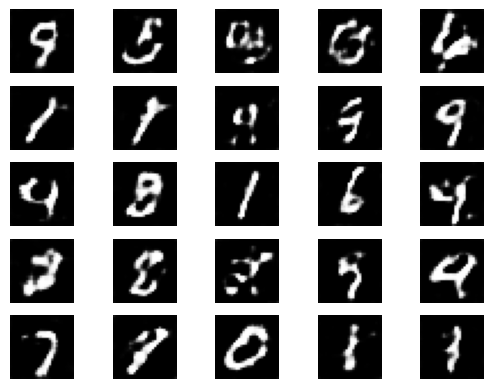

epoch: 1.43, loss_g: 1.1625, loss_d: 1.0097


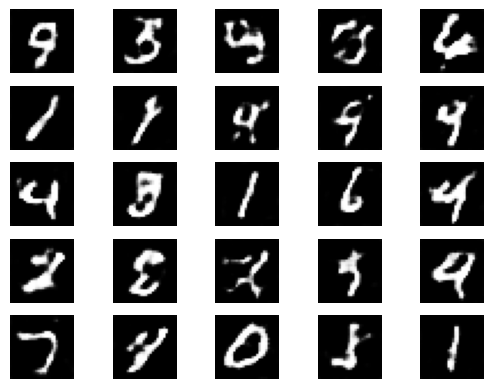

KeyboardInterrupt: 

In [4]:


use_gpu = cuda.gpu_enable
max_epoch = 5
batch_size = 128
hidden_size = 62

fc_channel, fc_height, fc_width = 128, 7, 7

gen = Sequential(
    L.Linear(1024),
    L.BatchNorm(),
    F.relu,
    L.Linear(fc_channel * fc_height * fc_width),
    L.BatchNorm(),
    F.relu,
    lambda x: F.reshape(x, (-1, fc_channel, fc_height, fc_width)),
    L.Deconv2d(fc_channel // 2, kernel_size=4, stride=2, pad=1),
    L.BatchNorm(),
    F.relu,
    L.Deconv2d(1, kernel_size=4, stride=2, pad=1),
    F.sigmoid
)

dis = Sequential(
    L.Conv2d(64, kernel_size=4, stride=2, pad=1),
    F.leaky_relu,
    L.Conv2d(128, kernel_size=4, stride=2, pad=1),
    L.BatchNorm(),
    F.leaky_relu,
    F.flatten,
    L.Linear(1024),
    L.BatchNorm(),
    F.leaky_relu,
    L.Linear(1),
    F.sigmoid
)


def init_weight(dis, gen, hidden_size):
    # Input dummy data to initialize weights
    batch_size = 1
    z = np.random.rand(batch_size, hidden_size)
    fake_images = gen(z)
    dis(fake_images)

    for l in dis.layers + gen.layers:
        classname = l.__class__.__name__
        if classname.lower() in ('conv2d', 'linear', 'deconv2d'):
            l.W.data = 0.02 * np.random.randn(*l.W.data.shape)

init_weight(dis, gen, hidden_size)

opt_g = Adam(alpha=0.0002, beta1=0.5).setup(gen)
opt_d = Adam(alpha=0.0002, beta1=0.5).setup(dis)

transform = lambda x: (x / 255.0).astype(np.float32)
train_set = dezero.datasets.MNIST(train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size)

if use_gpu:
    gen.to_gpu()
    dis.to_gpu()
    train_loader.to_gpu()
    xp = cuda.cupy
else:
    xp = np

label_real = xp.ones(batch_size).astype(int)
label_fake = xp.zeros(batch_size).astype(int)
test_z = xp.random.randn(25, hidden_size).astype(np.float32)


def generate_image():
    with dezero.test_mode():
        fake_images = gen(test_z)

    img = cuda.as_numpy(fake_images.data)
    plt.figure()
    for i in range(0, 25):
        ax = plt.subplot(5, 5, i+1)
        ax.axis('off')
        plt.imshow(img[i][0], 'gray')
    plt.show()
    #plt.savefig('gan_{}.png'.format(idx))

for epoch in range(max_epoch):
    avg_loss_d = 0
    avg_loss_g = 0
    cnt = 0

    for x, t in train_loader:
        cnt += 1
        if len(t) != batch_size:
            continue

        # (1) Update discriminator
        z = xp.random.randn(batch_size, hidden_size).astype(np.float32)
        fake = gen(z)
        y_real = dis(x)
        y_fake = dis(fake.data)
        loss_d = F.binary_cross_entropy(y_real, label_real) + \
                 F.binary_cross_entropy(y_fake, label_fake)
        gen.cleargrads()
        dis.cleargrads()
        loss_d.backward()
        opt_d.update()

        # (2) Update generator
        y_fake = dis(fake)
        loss_g = F.binary_cross_entropy(y_fake, label_real)
        gen.cleargrads()
        dis.cleargrads()
        loss_g.backward()
        opt_g.update()

        # Print loss & visualize generator
        avg_loss_g += loss_g.data
        avg_loss_d += loss_d.data
        interval = 100 if use_gpu else 5
        if cnt % interval == 0:
            epoch_detail = epoch + cnt / train_loader.max_iter
            print('epoch: {:.2f}, loss_g: {:.4f}, loss_d: {:.4f}'.format(
                epoch_detail, float(avg_loss_g/cnt), float(avg_loss_d/cnt)))
            generate_image()

In [ ]:
dis.save_weights("dis_weights.npz")
gen.save_weights("gen_weights.npz")
print(cuda.gpu_enable)

In [ ]:
import cupy as cp

In [ ]:
print(cp)